# Example 2 - Nesterov

This notebook compares **Gradient Descent (GD)** and **Nesterov's Accelerated Gradient (NAG)** variants on a convex function.

---

## Problem Setup
- **Function**:
  $$
  f(x) = \frac{1}{2}x^TQx + b^Tx
  $$
  - $Q$: Positive-definite matrix of size $100 \times 100$.
  - $b$: Random vector of size $100$.

- **Optimal Solution**:
  - $x^* = -Q^{-1}b$
  - $f^* = f(x^*)$

---

## Algorithms

### Gradient Descent (GD)
- **Update Rule**:
  $$
  x_{k+1} = x_k - \eta \nabla f(x_k)
  $$
- **Step Size**:
  $$
  \eta = \frac{1}{L}
  $$

---

### Nesterov's Accelerated Gradient (NAG)

#### Convex (Dynamic $\beta$)
- **Momentum**:
  $$
  \beta_k = \frac{k}{k+3}
  $$
- **Update Rule**:
  $$
  y_k = x_k + \beta_k (x_k-x_{k-1})
  $$
  $$
  x_{k+1} = y_k - \eta \nabla f(y_k)
  $$
- **Step Size**:
  $$
  \eta = \frac{1}{L}
  $$

#### Strongly Convex
- **Momentum**:
  $$
  \beta = \frac{\sqrt{L} - \sqrt{\mu}}{\sqrt{L} + \sqrt{\mu}}
  $$
- **Update Rule**:
  $$
  y_k = x_k + \beta (x_k-x_{k-1})
  $$
  $$
  x_{k+1} = y_k - \eta \nabla f(y_k)
  $$
- **Step Size**:
  $$
  \eta = \frac{1}{L}
  $$


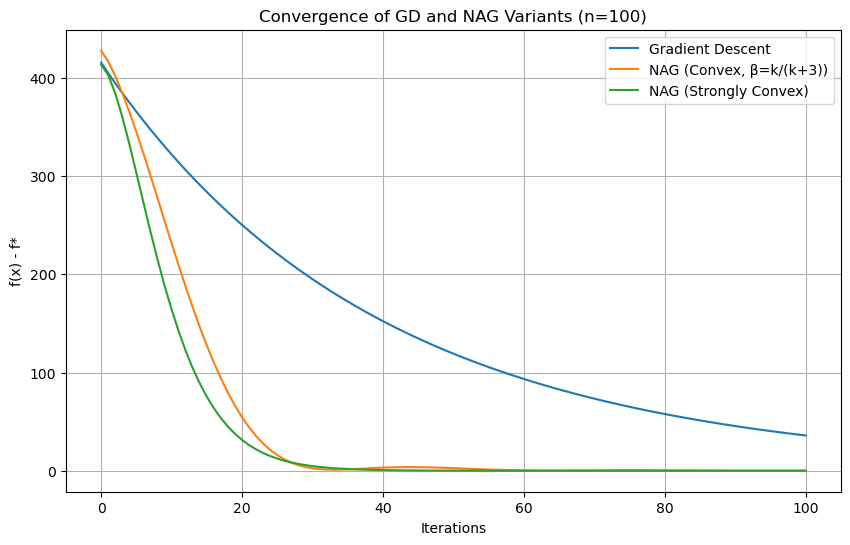

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Generate strongly convex function
def generate_strongly_convex(n=100, mu=0.1, L=10, seed=0):
    np.random.seed(seed)
    Q = np.random.rand(n, n)
    Q = Q.T @ Q  # Positive definite matrix
    Q = mu * np.eye(n) + (L - mu) * Q / np.max(np.linalg.eigvals(Q))  # Scale for strong convexity
    b = np.random.randn(n)
    return Q, b

def f(x, Q, b):
    return 0.5 * x.T @ Q @ x + b.T @ x

def grad_f(x, Q, b):
    return Q @ x + b

# Gradient Descent Implementation
def gradient_descent(Q, b, lr, iterations=100, x_init=None):
    if x_init is None:
        x_init = np.random.randn(Q.shape[0])
    x = x_init
    f_values = [f(x, Q, b)]
    for _ in range(iterations):
        grad = grad_f(x, Q, b)
        x -= lr * grad
        f_values.append(f(x, Q, b))
    return f_values

# Nesterov's Accelerated Gradient (Convex) with dynamic beta k/(k+3)
def nesterov_accelerated_gradient_convex_dynamic(Q, b, lr, iterations=100, x_init=None):
    if x_init is None:
        x_init = np.random.randn(Q.shape[0])
    x = x_init
    v = np.zeros_like(x)
    f_values = [f(x, Q, b)]
    for k in range(1, iterations + 1):
        beta = k / (k + 3)  # Dynamic momentum
        y = x + beta * v
        grad = grad_f(y, Q, b)
        v = beta * v - lr * grad
        x += v
        f_values.append(f(x, Q, b))
    return f_values

# Nesterov's Accelerated Gradient (Strongly Convex)
def nesterov_accelerated_gradient_strongly_convex(Q, b, lr, beta, iterations=100, x_init=None):
    if x_init is None:
        x_init = np.random.randn(Q.shape[0])
    x = x_init
    v = np.zeros_like(x)
    f_values = [f(x, Q, b)]
    for _ in range(iterations):
        y = x + beta * v
        grad = grad_f(y, Q, b)
        v = beta * v - lr * grad
        x += v
        f_values.append(f(x, Q, b))
    return f_values

# Generate problem
mu, L = 0.1, 10
Q, b = generate_strongly_convex(n=100, mu=mu, L=L, seed=42)
f_star = f(np.linalg.solve(Q, -b), Q, b)  # Optimal function value

# Run algorithms
gd_values = gradient_descent(Q, b, lr=1/L, iterations=100)
nag_dynamic_convex_values = nesterov_accelerated_gradient_convex_dynamic(Q, b, lr=1/L, iterations=100)
nag_strongly_convex_values = nesterov_accelerated_gradient_strongly_convex(
    Q, b, lr=1/L, beta=(np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu)), iterations=100
)

# Adjust function values for f(x) - f*
gd_adjusted = [val - f_star for val in gd_values]
nag_dynamic_convex_adjusted = [val - f_star for val in nag_dynamic_convex_values]
nag_strongly_convex_adjusted = [val - f_star for val in nag_strongly_convex_values]

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(gd_adjusted, label="Gradient Descent")
plt.plot(nag_dynamic_convex_adjusted, label="NAG (Convex, β=k/(k+3))")
plt.plot(nag_strongly_convex_adjusted, label="NAG (Strongly Convex)")
plt.xlabel("Iterations")
plt.ylabel("f(x) - f*")
plt.title("Convergence of GD and NAG Variants (n=100)")
plt.legend()
plt.grid()
plt.show()
